In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


X_train = pd.read_csv("../data/raw/X_train.csv", sep=",",index_col=0)
y_train = pd.read_csv("../data/raw/Y_train.csv", sep=",",index_col=0)

## Analyse de la taille des désignations et descriptions produits

### Travail exploratoire

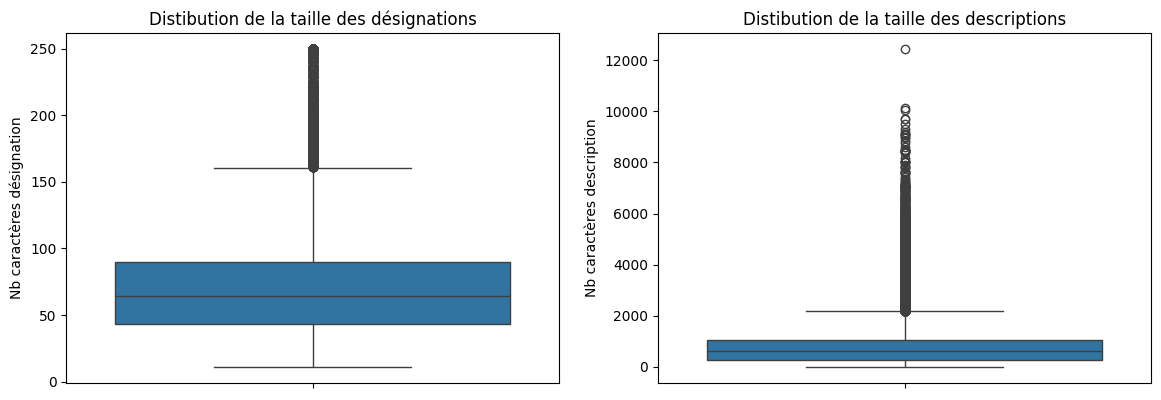

In [12]:
fig = plt.figure(figsize=(14,10))

plt.subplot(221)
sns.boxplot(X_train['designation'].str.len())
plt.ylabel("Nb caractères désignation")
plt.title("Distibution de la taille des désignations")

plt.subplot(222)
sns.boxplot(X_train['description'].str.len())
plt.ylabel("Nb caractères description")
plt.title("Distibution de la taille des descriptions")

plt.show()

###  Analyse et interprétation

Analyse des désignations:
- elles contiennent des noms de produits ou des descriptions courtes
- elles sont relativement courtes, avec une longueur médiane de 64 caractères
- la taille typique d'une désignation est comprise entre 43 et 90 caractères
- il y a peu de valeurs aberrantes et la distribution reste relativement homogène

Analyse de la distribution de la taille des description:
- elles sont beaucoup plus longues, avec une médiane de 626 caractères
- la variabilité est élevée, avec des valeurs extremes des valeurs extrême pouvant atteindre 10 000 caractères ou plus

Les descriptions, elles, fournissent plus de détails sur les caractéristiques des produits. Elles sont plus riches en contexte et peuvent être importante pour distinguer des produits similaires, surtout dans les cas où la désignation serait, elle, très courte. Toutefois, la présence de nombreuses valeurs aberrantes et la grande disparité des valeurs pourrait poser des problèmes lors de la modélisation (ex: temps de traitement très long, impact disproportionné ...)

## Analyse de la proportion de descriptions manquantes par catégorie

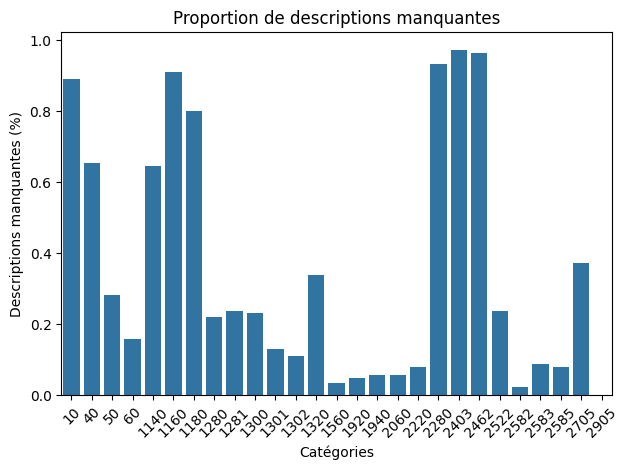

In [19]:
X_train_without_descr = X_train[X_train["description"].isna()]
y_train_without_descr = y_train.loc[X_train_without_descr.index,:]

# Proportion de description manquantes par classes
counts_prdtype = pd.DataFrame(y_train["prdtypecode"].value_counts())
counts_prdtype_without_descr = pd.DataFrame(y_train_without_descr["prdtypecode"].value_counts())

counts_prdtype = counts_prdtype_without_descr /  counts_prdtype

sns.barplot(y=counts_prdtype["count"], x=counts_prdtype.index)
plt.title("Proportion de descriptions manquantes")
plt.xlabel("Catégories")
plt.ylabel("Descriptions manquantes (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analyse et interprétation

Inégalité dans les descriptions manquantes :

*   Certaines catégories ont une très forte proportion de descriptions manquantes (autour de 90% et plus)
*   D'autres catégories ont une proportion beaucoup plus faible de descriptions manquantes, voire aucune

Risque pour la classification :

*   Les catégories avec une proportion élevée de descriptions manquantes risquent d’être mal représentées dans le modèle si celui-ci dépend fortement des descriptions
*   Certaines catégories seront principalement classées sur la base des désignations uniquement, ce qui peut réduire la précision si les désignations dans ces catégories ne sont pas assez informatives

## Analyse de la distribution des produits dans les catégories cibles

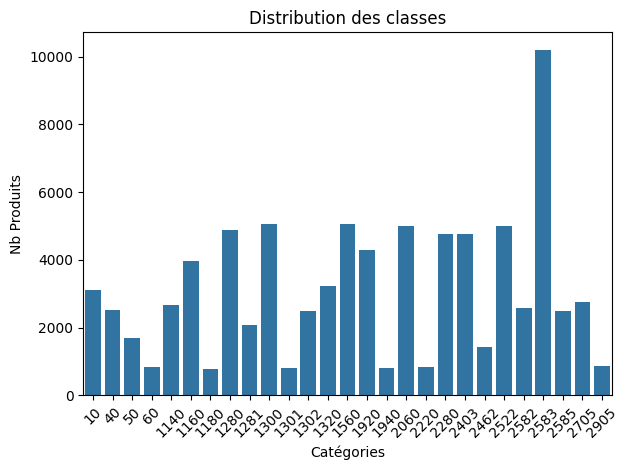

In [18]:
# répartition des effectifs par classes
sns.countplot(x = y_train["prdtypecode"])
plt.title("Distribution des classes")
plt.xlabel("Catégories")
plt.ylabel("Nb Produits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyse et interprétation

On observe un déséquilibre de la répartition des catégories

*   La catégorie 285 se démarque nettement avec un nombre de produits largement supérieur à toutes les autres (plus de 10 000 produits)
*   A l'inverse certaines catégories sont sous-représentées (quelques centaines de produits seulement)

Ce graphique met en évidence un problème de déséquilibre des classes dans les données, qui va falloir adresser car 
cela pourrait fausser les résultats de classification:
*   Le modèle pourrait prédire la classe "285" de manière excessive
*   La performance globale pourrait être artificiellement élevée, masquant une faible performance sur les catégories moins représentées

Pour gérer ce problème, il faudra surement faire appel à des techniques de rééchantillonnage (oversampling ou undersampling) et/ou de pondération. On pourra par exemple utiliser des poids inversément proportionnels à la fréquence des classes dans la fonction de perte du modèle.

## Analyse des langues utilisées dans les désignations et descriptions produits

In [20]:
from langdetect import detect, detect_langs
import pandas as pd

def identifier_langue(texte):
  return detect(str(texte))

X_train['texte_complet'] = X_train['designation'] + ' ' + X_train['description']

# on ne concerve que les produits avec une description pour garder un bon niveau de confiance
with_descr = X_train["description"].notna()
# Détection des langues
lang_with_descr = X_train[with_descr]['texte_complet'].apply(identifier_langue)

pandas.core.series.Series

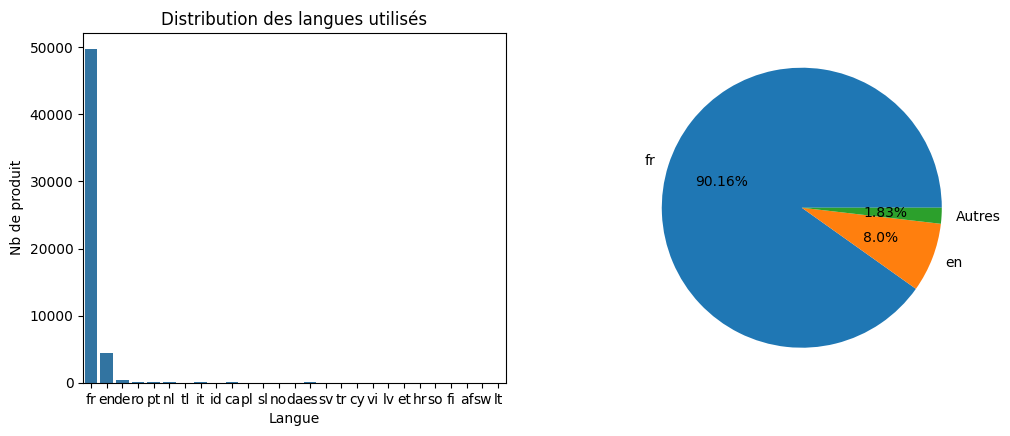

In [36]:
# répartition des effectifs par langue utilisé dans la description
plt.figure(figsize=(12,10))
plt.subplot(221)
sns.countplot(x = lang_with_descr)
plt.xlabel("Langue")
plt.ylabel("Nb de produit")
plt.title("Distribution des langues utilisés")

# répartition en %tage
langues_pct = lang_with_descr.value_counts(normalize=True)

plt.subplot(222)
counts = lang_with_descr.value_counts()

# On regroupe les langues trop peu présentes dans une même catégorie 
# pour conserver un affichage clair sur le graphe

seuil = 0.05 * counts.sum()

# Séparer les grandes valeurs des petites
lang_with_descr_counts = counts[counts >= seuil]
lang_with_descr_counts["Autres"] = counts[counts < seuil].sum()

plt.pie(lang_with_descr_counts, labels =lang_with_descr_counts.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title("Répartition des langues dans les descriptions produits")

plt.show()

###  Analyse et interprétation

L'analyse de la distribution nous permet de remarquer que:
- Le français représente environ 90 % des descriptions
- L'anglais représente une part visible, mais modeste (environ 10 %)
- toutes les autres langues combinées représentent une proportion négligeable, chacune étant inférieure à 1 %

\
*Warning: Il faut précisé ici que je n'ai pris en compte que les produits ayant une description (soit env 65% du dataset initial) car les désignations seules étaient souvent trop courtes pour permettre une détection fiable.*

\
Si on prend pour hypothèse que la distribution devrait être similaire dans les 35% d'observations écartées, nous pouvont conclure que l'écrasante majorité des descriptions produits sont en français.

C'est une information qui pourra être utile lorsque nous auront besoin de faire du traitement de type NLP sur ces données. On pourra, par exemple, dans un premier temps, ce concentrer sur l'optimisation du modèle uniquement pour la langue française.

Puis dans un deuxième temps explorer d'autres possibilités comme
- introduire une étape de normalisation des langues (traduction automatique vers le français)
- faire évolution notre modèle vers 

## Analyse des images

In [ ]:

import os
import numpy as np
import pandas as pd
from PIL import Image, ImageStat
import imagehash


def analyze_image_dataset(directory_path):
    """
    Retourne les données technique extraite de image pour analyse
    """

    dataset_stats = {
        'imageid': [],
        'productid': [],
        'height': [], 
        'width': [], 
        'modes': [], 
        'formats': [], 
        'ratios': [], 
        'file_sizes': [],
        'mean_luminosity':[],
        'mean_stddev_luminosity': [],
        "hash": []
        }
    
    
    for filename in os.listdir(directory_path):
        try:

            filepath = os.path.join(directory_path, filename)
            image = Image.open(filepath)
        
            # Récupération des id
            name, extension = os.path.splitext(filename)
            split_name = name.split("_")
            dataset_stats['imageid'].append(split_name[1])
            dataset_stats['productid'].append(split_name[3])

            # Caractéristiques techniques
            dataset_stats['height'].append(image.size[0] )
            dataset_stats['width'].append(image.size[1])
            dataset_stats['modes'].append(image.mode)
            dataset_stats['formats'].append(image.format)
            dataset_stats['ratios'].append(image.size[0] / image.size[1])
            dataset_stats['file_sizes'].append(os.path.getsize(filepath))
            
            # Analyse de la luminosité 
            if image.mode == 'RGB':
                image_stat = ImageStat.Stat(image)
                mean_luminosity = sum(image_stat.mean)/3
                mean_stddev_luminosity = sum(image_stat.stddev)/3
                dataset_stats['mean_luminosity'].append(mean_luminosity)
                dataset_stats['mean_stddev_luminosity'].append(mean_stddev_luminosity)
            
           
            # Calcule d'un hach perceptuel pour évaluer la proportion de doublon 
            phash = str(imagehash.phash(image))
            dataset_stats['hash'].append(phash)

        except Exception as e:
            print(f"Erreur lors de l'analyse de {filename}: {str(e)}")
            
    return dataset_stats

# Script de génération du dataset de données concernant les images
if(False):
    img_train_rep = "/mnt/c/Users/karim/Downloads/images/images/image_train"
    analyzed_img = analyze_image_dataset(img_train_rep)
    df_analyzed_img = pd.DataFrame(analyzed_img)
    df_analyzed_img.to_csv("../../data/raw/image_train.csv") # dump du dataframe

In [46]:
image_train = pd.read_csv("../data/raw/image_train.csv", sep=",",index_col=0)
display(image_train.describe())
print("le dataset contient {} doublons".format(image_train.duplicated(subset="hash").sum()))

# merge des dataframe pour faciliter l'exploration
train = pd.concat([X_train, y_train], axis=1)
train = pd.merge(train, image_train, how="inner", left_on=["productid", "imageid"], right_on=["productid", "imageid"])
train["duplicated"] = train.duplicated(subset="hash") 
84916 

,imageid,productid,height,width,ratios,file_sizes,mean_luminosity,mean_stddev_luminosity
count,8.491600e+04,8.491600e+04,84916.0,84916.0,84916.0,84916.000000,84916.000000,84916.000000
mean,1.152691e+09,2.555468e+09,500.0,500.0,1.0,26581.791535,195.774120,63.744737
std,1.751427e+08,1.588656e+09,0.0,0.0,0.0,13845.766608,41.127735,22.132966
min,6.728400e+04,1.839120e+05,500.0,500.0,1.0,2061.000000,4.177464,0.000000
25%,1.056269e+09,6.760519e+08,500.0,500.0,1.0,15712.750000,168.361869,47.870512
50%,1.213354e+09,3.190506e+09,500.0,500.0,1.0,24531.500000,203.464844,65.577687
75%,1.275646e+09,3.995599e+09,500.0,500.0,1.0,35613.000000,229.240259,80.428160
max,1.328824e+09,4.252012e+09,500.0,500.0,1.0,106720.000000,255.000000,126.253580


le dataset contient 7590 doublons


### Analyse générale du dataset

 - le dataset contient uniquement des images carrées de dimension 500x500 pixels. On peut supposer quelles sont formatés avant usage et qu il en sera de même pour les futures images à analyser
 - les images sont toutes au format JPEG et utilise le mode RGB
 - en terme de taille de fichier le dataset semble homogènes, les fichiers font typiquement en 15Ko et 35Ko et n'exède pas les 110Ko
 - sur la base d'une comparaison des hash perceptuel 7590 doublons ont été identifiés soit environ 9% du dataset. Nous allons étudier plus en détail ce point car il pourrait s'avérer problèmatique lors de la phase de modélisation


### Analyse de la luminosité et du contraste

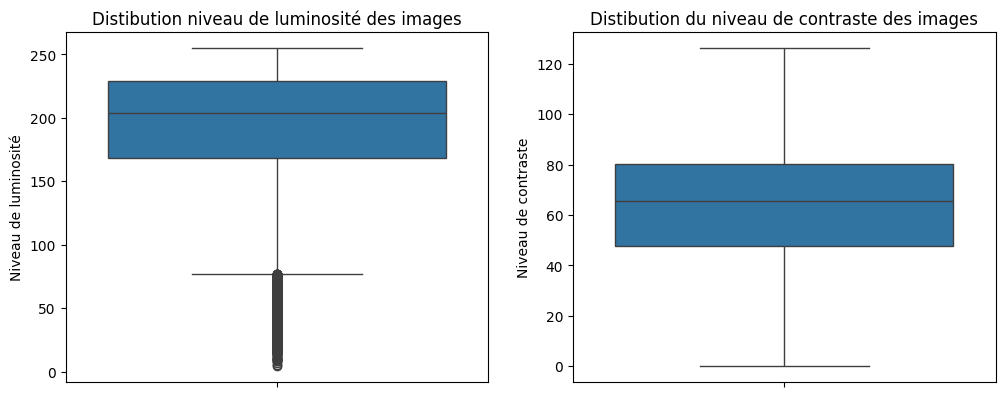

In [102]:
plt.figure(figsize=(12,10))

plt.subplot(221)
sns.boxplot(train["mean_luminosity"])
plt.ylabel("Niveau de luminosité")
plt.title("Distibution niveau de luminosité des images")

plt.subplot(222)
sns.boxplot(train["mean_stddev_luminosity"])
plt.ylabel("Niveau de contraste")
plt.title("Distibution du niveau de contraste des images")

plt.show()

### Analyse et interprétation

**Distribution du niveau de luminosité**
- La majorité des images a une luminosité entre 170 et 230
- La médiane se situe autour de 200
- Cette distribution indique que les images sont généralement très lumineuses 
- Il y a des valeurs aberrantes en dessous de 50, indiquant quelques images très sombres dans le dataset

La fait que la majorité des images soient lumineuses, voir très lumineuses peux s'expliquer par le fait que les images contiennent une grande proportion de blanc.
Il semble que le traitement qui normalise la taille des images, rajoute un fond blanc pour arriver à un format carrée de 500 pixels côté. Si l'image d'origine est petite cela aboutie à une image majoritairement blanche ce qui pourrait être problématique pour l'analyse par la suite.
Par ailleurs, si on analyse les valeurs aberrantes (ie en dessous de 50) on constate qu'il s'agit souvent d'images de produits présentés sur fond noir ou mis en scéne dans un contexte nocture.


**Distribution du niveau de contraste** 
- Le contraste se situe principalement entre 45 et 80
- La médiane est autour de 65
  
Si on considère l'échelle de valeurs suivante pour le contraste
- inférieur 20 = contraste très faible
- entre 20 et 40 = contraste faible
- entre 40 et 80 = contraste moyen
- entre 80 et 100 = contraste élevé
- supérieur 100 = contraste très élevé

On peut en déduire que 
  - La majorité des images se situe dans la zone de contraste "moyen"
  - Peu d'images ont un contraste faible (< 40) ou très élevé (> 100)
  - La distribution est relativement équilibrée autour de la médiane


En conclusion, le niveau de contraste semble approprié pour la plupart des images, suggérant une bonne qualité générale du dataset.

Pour garantir une bonne performance du modèle, il faudra peut être envisager quelques traitements:
- cropper les images pour retirer le remplissage blanc inutile qui risque de polluer l'analyse sur une grand nombre images ou écarter ces images (ie celles avec une luminosité très élevée)
- écarter les images avec un contrastre trop faible (ie <20) car se sont souvent des images quasiment monochromes difficile à interpréter
- faire un traitement sur les images pour essayer de maintenir un niveau global du contraste supérieur à 40
- décidé d'une stratégie sur les images avec un luminosité très basse, essayer un traitement ou les retirer du dataset


### Analyse des doublons

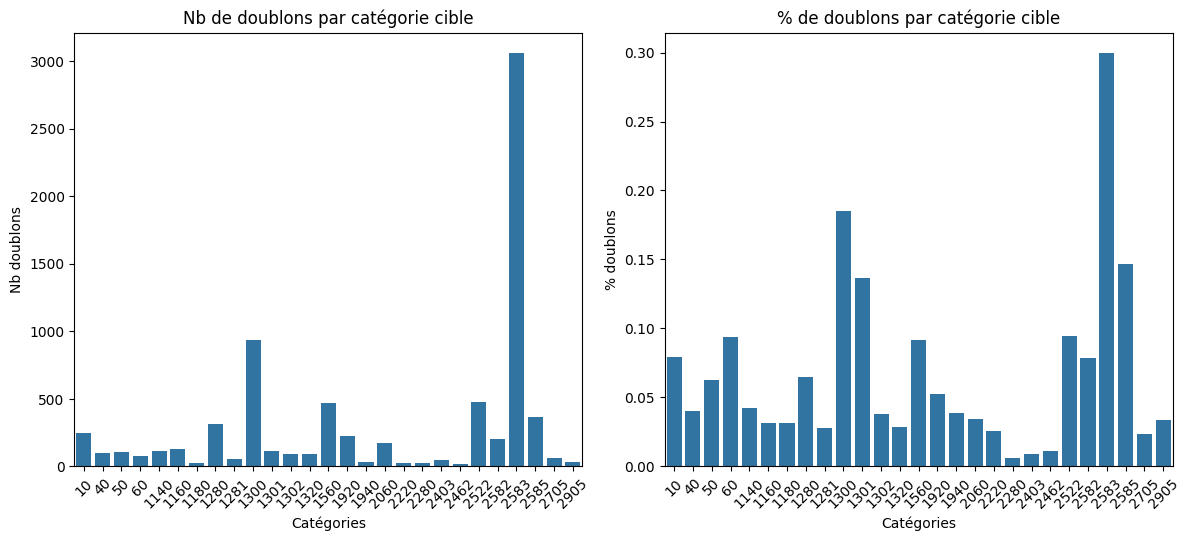

In [100]:
train = pd.concat([X_train, y_train], axis=1)
train = pd.merge(train, image_train, how="inner", left_on=["productid", "imageid"], right_on=["productid", "imageid"])

train["duplicated"] = train.duplicated(subset="hash")

duplicated = train.groupby("prdtypecode")["duplicated"].sum()
duplicated_normalized = train.groupby("prdtypecode")["duplicated"].mean()

plt.figure(figsize=(12,10))
plt.subplot(221)

# Nombre de doublon d'image par catégorie cible
sns.barplot(y=duplicated, x=duplicated.index)
plt.title("Nb de doublons par catégorie cible")
plt.xlabel("Catégories")
plt.ylabel("Nb doublons")
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(222)

# Nombre de doublon d'image par catégorie cible
sns.barplot(y=duplicated_normalized, x=duplicated_normalized.index)
plt.title("% de doublons par catégorie cible")
plt.xlabel("Catégories")
plt.ylabel("% doublons")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Analyse et interprétation

**Volume de doublons par catégorie:**

- La catégorie 2583 se démarque très nettement avec environ 3000 doublons
- La catégorie 1300 a également un nombre important de doublons (environ 900)
- La majorité des autres catégories ont moins de 500 doublons

**Pourcentage de doublons par catégorie:**

- Le plus haut pourcentage de doublons est d'environ 30% (sur la catégorie 2583 qui est aussi celle avec le plus de doublon)
- Trois autres catégories ont un proportion notable autour de 15-18% 
- Sinon la plupart des catégories ont moins de 10% de doublons

Les catégories 2583 et 1300 qui comportent les volumes et pourcentage de doublon les plus important vont nécessité une investigation particulière.
Le problème que l'on pourrait rencontré serait un surapprentissage du modèle par rapport à ces images en doublon trop présente, ce qui pourrait empêcher notre modèle de bien généraliser sur des images inconnues. 

A noter, la méthode utilisée pour générer les hash perceptuels, dégrade l'image pour calculer son "empreinte". En particulier, l'image est redimensionnée en 32x32 pixels et convertie en niveau de gris.
Les nombreuses images de produit trop petites comme celles identifiées lors de l'analyse de la luminosité ont de forte chance de générer des faux positifs qui gonflent un peu le nombre de doublons.
Il faudra donc surement adresser ce sujet des doublons seulement après fait les traitements ou suppressions nécessaire sur les images problématiques.